Microwave Ramsey Experiment in $^{87}$Rb clock states, with varied AC Stark shift from 780 nm beam in gap time.

In [1]:
#### libraries
from matplotlib import pyplot as plt
from sympy import symbols,N,sympify,lambdify
from sympy import MatrixSymbol,MatAdd,MatMul,Identity as eye,Matrix,zeros
from sympy.utilities.iterables import flatten
import numpy as np
from numpy import *
from scipy.integrate import solve_ivp

#### local files
from rbconsts import *
from physconsts import *
from amophys import *
from rbensemble import RbEnsemble as ensemble

#### layout stuff
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

In [30]:
#### functions 

def intensity(x,y,z,lmbda,wx,I0,wy=None,z_offset=0):
    if wy is None:
        wy = wx

    zRx = z_rayleigh(lmbda,wx)
    zRy = z_rayleigh(lmbda,wy)

    wzx = (1+(z/zRx)**2)
    wzy = (1+((z-z_offset)/zRy)**2)
    return I0*exp(-2*x**2/(wx*wzx)**2-2*y**2/(wy*wzy)**2) # double check this!!! 

def rabi(I0,matelem):
    """ the rabi frequency for a beam of intensity I0 coupling states |e>,|g>
        such that matelem = <e|q x|g>. May need to include a coupling const. 
        as prefactor on matelem. 
    """
    return sqrt(2*I0/(c*e0))*matelem/hbar 

def mw_pulse(y0,dt,D,Omega):
    """ return the state after a mw pulse lasting dt.
        'y0' initial state"""

    derivs = lambda t,y: obe_derivs(y,t,D,Omega)
    soln = solve_ivp(derivs,[0,dt],y0=y0)
    
    return [y[-1] for y in soln.y] # the final state

def gap_evolve(y0,D,t_gap):
    """ return the state after gap time evolution """
    
    y0[2] *= exp(-1j*D*t_gap) # rotate r_eg about z
    return y0

C:\Users\gothr\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


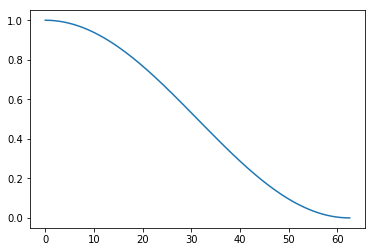

In [3]:
# test the microwave rfe
D_mw = 0 # microwave detuning
Omega = 2*pi*8e3 # roughly. see minho's thesis
derivs = lambda t,y: obe_derivs(y,t,D_mw,Omega)
tscale = 1e-6
y0 = array([1+0j,0+0j,0+0j])
tpi = (pi/Omega)
t_exp = tpi
soln = solve_ivp(derivs,[0,t_exp],y0,t_eval=linspace(0,t_exp,2000))
plt.plot(soln.t/tscale,soln.y[0])

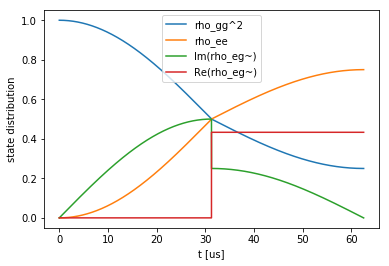

In [22]:
#### Example data point for Ramsey fringe: 
# (1) pi/2 pulse. This sets r_eg to be .5 along imaginary axis in equatorial plane (kind of)
# (2) gap time. in a frame rotating at the transition freq, r_eg will rotate due to environmental noise
# to some angle phi after some gap time such that it is has both real and imag projections. 
# (3) pi/2 pulse. This will not fully invert the initial state if r_eg has rotated other than 2*pi*n, n=0,1,2..
# it is clear that the pi/2 pulse is a torque about the rho_eg real axis
y0 = array([1+0j,0+0j,0+0j])
t_exp = tpi/2
derivs = lambda t,y: obe_derivs(y,t,D_mw,Omega)
soln_mw1 = solve_ivp(derivs,[0,t_exp],y0,t_eval=linspace(0,t_exp,2000)) # 1st pi/2 pulse
y1 = [y[-1] for y in soln_mw.y]
y1[2] *= exp(-1j*pi/6) # rotate r_eg in equatorial plane (let precess due to state energy shift for some gap time)
soln_mw2 = solve_ivp(derivs,[t_exp,2*t_exp],y1,t_eval=linspace(t_exp,2*t_exp,2000)) # 2nd pi/2 pulse
soln_y = [append(soln_mw1.y[i],soln_mw2.y[i]) for i in range(len(y1))]
soln_t = append(soln_mw1.t,soln_mw2.t)/tscale
plt.plot(soln_t,soln_y[0],label="rho_gg^2")
plt.plot(soln_t,soln_y[1],label="rho_ee")
plt.plot(soln_t,imag(soln_y[2]),label="Im(rho_eg~)")
plt.plot(soln_t,real(soln_y[2]),label="Re(rho_eg~)")
plt.ylabel("state distribution")
plt.xlabel("t [us]")
plt.legend()
plt.show()

try to simulate noise in the gap time with an operation that moves
$\rho_{eg}$ such that it now has a real component. if it precesses about
the z axis at $\Delta$, then the final angle after time T is $\phi = \Delta$T.
Now a microwave applied will provide a torque about Re[$\rho_{eg}$] ($\rho$ isn't really
an object that lives on the Bloch sphere but this still makes some sense) and
the state will "miss" the pole as it swings out. 

In [123]:
#### the ramsey experiment - no averaging
# during the time, there is some energy shift between the states according
# to normal distribution so the qubit precesses at nominally at this detuning 
# frequency. However because the shift is jittering around there is decay 
# in the oscillations.

y0 = array([1+0j,0+0j,0+0j])
y = 0
Omega = 1
tpi = pi/Omega
Dbar = 2*pi # mean energy difference shift during gap time
pts = 300 # pts per experiment
gsoln = empty(pts,complex) # ground state probabilities
t_gaplist = linspace(0,20*2*pi/D,pts)
for i in range(pts):
    y = mw_pulse(y0,tpi/2,0,Omega) 
    y = gap_evolve(y,np.random.normal(Dbar,.01*Dbar),t_gaplist[i])
    y = mw_pulse(y,tpi/2,0,Omega)
    gsoln[i] = y[0]

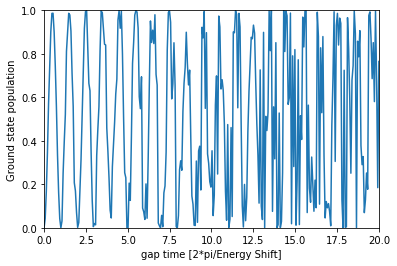

In [124]:
plt.plot(t_gaplist,real(gsoln))
plt.xlabel("gap time [2*pi/Energy Shift]")
plt.ylabel("Ground state population")
plt.xlim((0,t_gaplist[-1]))
plt.ylim((0,1))
plt.show()

In [136]:
#### the ramsey experiment - with averaging
y0 = array([1+0j,0+0j,0+0j])
y = 0
Omega = 1
tpi = pi/Omega
Dbar = 2*pi # mean energy difference shift during gap time
pts = 300 # pts per experiment
runs = 100 # times to run the experiment
gsoln = zeros(pts,complex) # ground state probabilities
t_gaplist = linspace(0,20*2*pi/D,pts)
for j in range(runs):
    for i in range(pts):
        y = mw_pulse(y0,tpi/2,0,Omega) 
        y = gap_evolve(y,np.random.normal(Dbar,.02*Dbar),t_gaplist[i])
        y = mw_pulse(y,tpi/2,0,Omega)
        gsoln[i] += y[0] # add to gsoln[i] each iteration each run
gsoln /= runs # divide the solution element-wise by # of runs to avg

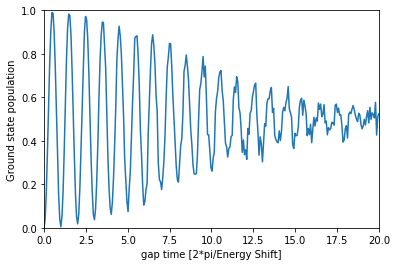

In [137]:
plt.plot(t_gaplist,real(gsoln))
plt.xlabel("gap time [2*pi/Energy Shift]")
plt.ylabel("Ground state population")
plt.xlim((0,t_gaplist[-1]))
plt.ylim((0,1))
plt.show()

# The Microwave Ramsey Experiment
## TODO
- take into account vector shift from 780($\sigma^+$)
- include coupling constant in calculation of 780 rabi freq
- find a way to account for noise on the 780 and finite linewidth (find papers?)

In [11]:
hf_levels

[{'n': 5, 'L': 0, 'J': 0.5, 'F': 1, 'nu': -4.271676631815196},
 {'n': 5, 'L': 0, 'J': 0.5, 'F': 2, 'nu': 2.563005979089114},
 {'n': 5, 'L': 1, 'J': 0.5, 'F': 1, 'nu': 377106.953053064},
 {'n': 5, 'L': 1, 'J': 0.5, 'F': 2, 'nu': 377107.769709364},
 {'n': 5, 'L': 1, 'J': 1.5, 'F': 0, 'nu': 384230.1823946245},
 {'n': 5, 'L': 1, 'J': 1.5, 'F': 1, 'nu': 384230.2546166565},
 {'n': 5, 'L': 1, 'J': 1.5, 'F': 2, 'nu': 384230.4115571805},
 {'n': 5, 'L': 1, 'J': 1.5, 'F': 3, 'nu': 384230.6782093585}]

In [105]:
#### naively calculate the peak hf energy level splitting due to 780A
## the result is reasonable but this neglects the 780A vector shift 
## and coupling constants. overshoots by about factor of 2

# 780A parameters
lmbda780 = 7.8e-7
wx0_780 = 6e-6 # [m]
wy0_780 = 9e-6 # [m]
dz = 260e-6 # wiki 2015.7.17, x-y foci axial displacement
area780 = pi*wx0_780*wy0_780*sqrt(1+(dz*lmbda780/(pi*wy0_780**2))**2) # area [m^2]
power780 = 8e-6 # [W]
efield780 = sqrt(4*power780/(c*e0*area780)) # the electric field amplitude

I780 = power780/area780
rabi780 = rabi(I780,D2_MatElem)
UacFORT = kB*Tdepth # [J]
hf_split = 2*pi*(hf_levels[1]["nu"] - hf_levels[0]["nu"])*1e9 # [rad/s]

# 780 detuning from the 5p3/2 COM; Minho's thesis and steck data
D780 = 2*pi*(2.1e9 - (hf_levels[-1]["nu"]*1e9 - omega_D2/(2*pi))) # [rad/s]

# ac stark shifts of each hf level
U_ac2 = - rabi780**2/(4*(D780 + UacFORT/hbar))
U_ac1 = - rabi780**2/(4*(D780 + UacFORT/hbar + hf_split))

D_hf = (U_ac2 - U_ac1)
print(f"D_hf = 2*pi*{D_hf/(2*1e6*pi)} [MHz]") 

D_hf = 2*pi*-8.172574129292707 [MHz]


In [106]:
D780/(2*pi*1e9), hf_split/(2*pi*1e9), UacFORT/(2*pi*1e9*hbar), rabi780/(2*pi*1e9)

(1.906259154, 6.834682610904309, 0.03125608373848702, 0.285119569493427)

In [107]:
#### calculate D_hf as defined above for random atom positions distributed in the FORT 

# our dipole trap and atom position distribution
w0_FORT = 2.5e-6
Tdepth = 1.5e-3 # [K]
Tatom = 5e-5 # [K]
FORT = dipole_trap(1.064e-6,w0_FORT,Tdepth,Tatom) # at 1064 nm
pts = 500 # pts per experiment
runs = 200 # times to run the experiment
position_arr = FORT.xdist(pts*runs)

# 780 detuning from the 5p3/2 COM; Minho's thesis and steck data
D780 = 2*pi*(2.1e9 - (hf_levels[-1]["nu"]*1e9 - omega_D2/(2*pi))) # [rad/s]

# ac stark shifts of each hf level
D_hf = array([-rabi780**2/(4*(D780 + FORT.U(x,y,z)/hbar)) - \
               -rabi780**2/(4*(D780 + FORT.U(x,y,z)/hbar + hf_split)) \
               for x,y,z in transpose(position_arr)]) # [rad/s]
D_hf_mean = mean(D_hf)
print(f"mean(D_hf) = 2*pi*{D_hf_mean/(2*1e6*pi)} [MHz]")

mean(D_hf) = 2*pi*-8.492508086272883 [MHz]


In [108]:
#### the ramsey experiment - 780A differential AC stark shift in gap time
## TODO: 
## - need to include hf_coupling (F',mF' = 3,1)
## - include vector shift from 780A; need to calculate alpha1 for that -.-

# runs,pts defined above
y0 = array([1+0j,0+0j,0+0j])
y = 0
Omega = 1
tpi = pi/Omega
gsoln = zeros(pts,complex) # ground state probabilities
t_gaplist = linspace(0,1e-5,pts) # pts defined in cell with stark shifts above
for j in range(runs):
    for i in range(pts):
        y = mw_pulse(y0,tpi/2,0,Omega) 
        y = gap_evolve(y,D_hf[i]/2.66,t_gaplist[i])
        y = mw_pulse(y,tpi/2,0,Omega)
        gsoln[i] += y[0] # add to gsoln[i] each iteration each run
gsoln /= runs # divide the solution element-wise by # of runs to avg
print("finished")

finished


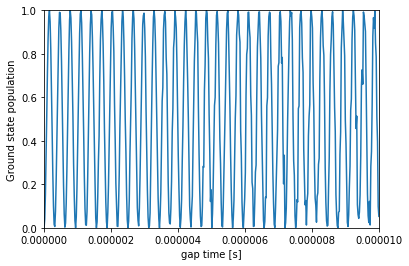

In [109]:
plt.plot(t_gaplist,real(gsoln))
plt.xlabel("gap time [s]")
plt.ylabel("Ground state population")
plt.xlim((0,t_gaplist[-1]))
plt.ylim((0,1))
plt.show()